In [1]:
import torch 
from ultralytics import YOLO

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


image 1/1 C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\2.jpg: 640x640 1 spot, 379.6ms
Speed: 7.0ms preprocess, 379.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


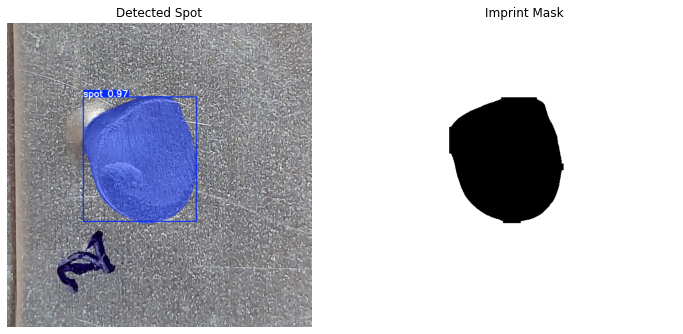

In [31]:
model = YOLO('best.pt')

img_no=2
img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#results = model(img_path)

results = model(img_path,
                conf=0.1,
                iou=0.4,
                agnostic_nms=True,
                max_det=1)

# for r in results:
#     r.show()

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(results[0].plot(),cv2.COLOR_BGR2RGB))
plt.title('Detected Spot')
plt.axis('off')

# Code to see the imprint

mask = 1- results[0].masks.data[0].detach().numpy()
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Imprint Mask")
plt.axis('off')
plt.show()



In [3]:
# function which gives the padding

def expand_crop(x1, y1, x2, y2, padding, img_shape):
    h, w = img_shape[:2]
    x1_p = max(0, x1 - padding)
    y1_p = max(0, y1 - padding)
    x2_p = min(w, x2 + padding)
    y2_p = min(h, y2 + padding)
    return x1_p, y1_p, x2_p, y2_p

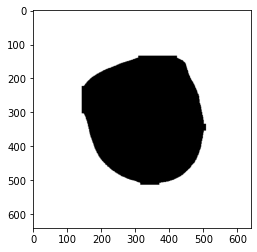

In [33]:
# Code for cropping the original image to the bounding box dimensions with some padding

box = results[0].boxes.xyxy[0].detach().numpy()
x1, y1, x2, y2 = map(int, box)

sample=img[y1:y2,x1:x2]

x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
cropped_img = img[y1_p:y2_p, x1_p:x2_p]
plt.imshow(cropped_img)

mask=cv2.resize(mask,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_NEAREST)
mask=mask[y1_p:y2_p,x1_p:x2_p]
mask=cv2.resize(mask,(640,640))
plt.imshow(mask,cmap='gray')


In [34]:
#Code to display/draw all the detected circles


# gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)

# # Apply Gaussian Blur to reduce noise
# blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# # Detect circles using HoughCircles
# circles = cv2.HoughCircles(
#     blurred,
#     cv2.HOUGH_GRADIENT,
#     dp=1.2,
#     minDist=100,
#     param1=50,
#     param2=40,
#     minRadius=350,
#     maxRadius=450
# )

# output = cropped_img.copy()

# if circles is not None:
#     circles = np.round(circles[0, :]).astype("int")

#     for (x, y, r) in circles:
#         # Draw outer circle
#         cv2.circle(output, (x, y), r, (0, 255, 0), 2)
#         # Draw center point
#         cv2.circle(output, (x, y), 2, (0, 0, 255), 3)

#     # If needed, crop around the largest circle
#     # (optional, based on your previous logic)
#     largest_circle = max(circles, key=lambda c: c[2])  # by radius
#     x, y, r = largest_circle
#     crop = img[y - r:y + r, x - r:x + r]
#     diameter = 2 * r
# else:
#     print("No circles detected.")
#     crop = img

# # Show result
# plt.figure(figsize=(6, 6))
# plt.imshow(output)
# plt.title("All Detected Circles")
# plt.axis('off')
# plt.show()

Max Diameter Detected: 898 pixels


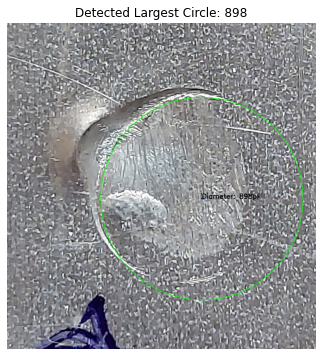

In [35]:
#Code to display only the largest diameter circle


gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise (important for HoughCircles)
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=50,   # Higher threshold for internal Canny (not related to Canny usage outside Hough)
    param2=40,   # Circle detection threshold (reduce if nothing found)
    minRadius=350,
    maxRadius=450
)

output = cropped_img.copy()
# Draw the largest detected circle
if circles is not None:
    # Round and take only the first circle
    x, y, r = np.round(circles[0][0]).astype("int")

    # Draw only that circle
    cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
    cv2.putText(output,
            f"Diameter: {2*r}px",
            (x, y),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,              # Font scale
            (0, 0, 0),    # Text color (Blue)
            2,              # Thickness
            cv2.LINE_AA)

    # Crop around this circle
    crop = img[y - r:y + r, x - r:x + r]
else:
    print("No circles detected.")
    crop = cropped_img

diameter = 2 * r

print(f"Max Diameter Detected: {diameter} pixels")

# Display
plt.figure(figsize=(6, 6))
plt.imshow(output)
plt.title(f"Detected Largest Circle: {diameter}")
plt.axis('off')
plt.show()
#cv2.imwrite(rf"Diameter\{img_no}.jpg",output)


In [36]:
H_orig, W_orig = output.shape[:2]

# Resize target
H_new, W_new = 640, 640

# Scaling factors
scale_x = W_new / W_orig
scale_y = H_new / H_orig

# Rescaled circle center and radius
cx_resized = int(x * scale_x)
cy_resized = int(y * scale_y)
r_resized  = int(r * (scale_x + scale_y) / 2)

print(f"Resized x,y,r: {cx_resized},{cy_resized},{r_resized}")


Resized x,y,r: 403,345,203


In [37]:
H, W = 640, 640

# Circle parameters (already scaled)


# Create coordinate grid
yy, xx = np.ogrid[:H, :W]


# Generate binary mask with circle
circle_binary_mask = np.ones((H, W), dtype=np.uint8)  # all 1s
circle_binary_mask[(xx - cx_resized)**2 + (yy - cy_resized)**2 <= r_resized**2] = 0  # set inside circle to 0






# fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# axs[0].imshow(output)
# axs[0].set_title("Detected Largest Circle")
# axs[0].axis('off')
# axs[0].set_aspect('equal')

# axs[1].imshow(circle_binary_mask, cmap='gray')
# axs[1].set_title("Binary Circle Mask (0 inside, 1 outside)")
# axs[1].axis('off')
# axs[1].set_aspect('equal')

# axs[2].imshow(mask, cmap='gray')
# axs[2].set_title("Spot Area")
# axs[2].axis('off')
# axs[2].set_aspect('equal')

# plt.tight_layout()
# plt.show()

width_per_pixel=22/2604
height_per_pixel=41/4624
real_diameter=2*r*width_per_pixel
print(f"Real_world Diameter: {real_diameter:.3f} mm")
print(output.shape)

Real_world Diameter: 7.587 mm
(1449, 1372, 3)


In [10]:
# # This code is to get all plots and diameter and spot percentage result in a for loop

# for i in range(30,35):
#     img_no=i
#     img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#     #results = model(img_path)

#     results = model(img_path,
#                 conf=0.1,
#                 iou=0.4,
#                 agnostic_nms=True,
#                 max_det=1)
    
#     mask = 1- results[0].masks.data[0].detach().numpy()

#     box = results[0].boxes.xyxy[0].detach().numpy()
#     x1, y1, x2, y2 = map(int, box)
#     # cropped_img = img[y1:y2, x1:x2]

#     x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
#     cropped_img = img[y1_p:y2_p, x1_p:x2_p]
#     # plt.imshow(cropped_img)

#     mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
#     mask= mask[y1_p:y2_p, x1_p:x2_p]
#     mask=cv2.resize(mask,(640,640))


#     gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)

#     # Apply Gaussian Blur to reduce noise (important for HoughCircles)
#     blurred = cv2.GaussianBlur(gray, (9, 9), 2)

#     # Detect circles using HoughCircles
#     circles = cv2.HoughCircles(
#         blurred,
#         cv2.HOUGH_GRADIENT,
#         dp=1.2,
#         minDist=100,
#         param1=50,   # Higher threshold for internal Canny (not related to Canny usage outside Hough)
#         param2=40,   # Circle detection threshold (reduce if nothing found)
#         minRadius=350,
#         maxRadius=450
#     )

#     output = cropped_img.copy()
#     # Draw the largest detected circle
#     if circles is not None:
#         # Round and take only the first circle
#         x, y, r = np.round(circles[0][0]).astype("int")

#         # Draw only that circle
#         cv2.circle(output, (x, y), r, (0, 255, 0), 2)
#         cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
#         cv2.putText(output,
#                 f"Diameter: {2*r}px",
#                 (x, y),
#                 cv2.FONT_HERSHEY_SIMPLEX,
#                 2,              # Font scale
#                 (0, 0, 0),    # Text color (Blue)
#                 3,              # Thickness
#                 cv2.LINE_AA)

#         # Crop around this circle
#         crop = img[y - r:y + r, x - r:x + r]
#     else:
#         print("No circles detected.")
#         crop = cropped_img

#     diameter = 2 * r

    

#     # Display
#     # plt.figure(figsize=(6, 6))
#     # plt.imshow(output)
#     # plt.title(f"Detected Largest Circle: {diameter}")
#     # plt.axis('off')
#     # plt.show()
    
#     H_orig, W_orig = output.shape[:2]

#     # Resize target
#     H_new, W_new = 640, 640

#     # Scaling factors
#     scale_x = W_new / W_orig
#     scale_y = H_new / H_orig

#     # Rescaled circle center and radius
#     cx_resized = int(x * scale_x)
#     cy_resized = int(y * scale_y)
#     r_resized  = int(r * (scale_x + scale_y) / 2) 

#     H, W = 640, 640  
#     yy, xx = np.ogrid[:H, :W]

#     # Generate binary mask with circle
#     circle_binary_mask = np.ones((H, W), dtype=np.uint8)  # all 1s
#     circle_binary_mask[(xx - cx_resized)**2 + (yy - cy_resized)**2 <= r_resized**2] = 0  # set inside circle to 0

#     inside_circle = (circle_binary_mask == 0)

# # 2. Get boolean mask of pixels that are part of the spot (mask == 0)
#     spot_pixels = (mask == 0)

#     # 3. Intersection: pixels that are both inside the circle AND part of the spot
#     spot_inside_circle = np.logical_and(inside_circle, spot_pixels)

#     # 4. Calculate percentage
#     total_circle_pixels = np.sum(inside_circle)
#     covered_by_spot = np.sum(spot_inside_circle)

#     coverage_percentage = (covered_by_spot / total_circle_pixels) * 100


#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#     fig.suptitle(f"Results for Spot {i}", fontsize=16)

#     axs[0].imshow(output)
#     axs[0].set_title("Detected Largest Circle")
#     axs[0].axis('off')
#     axs[0].set_aspect('equal')

#     axs[1].imshow(circle_binary_mask, cmap='gray')
#     axs[1].set_title("Binary Circle Mask (0 inside, 1 outside)")
#     axs[1].axis('off')
#     axs[1].set_aspect('equal')

#     axs[2].imshow(mask, cmap='gray')
#     axs[2].set_title("Spot Area")
#     axs[2].axis('off')
#     axs[2].set_aspect('equal')

#     plt.tight_layout()
#     plt.show()

#     width_per_pixel=22/2604
#     height_per_pixel=41/4624
#     avg_per_pixel=(width_per_pixel+height_per_pixel)/2
#     real_diameter=2*r*width_per_pixel
#     print(f"Real_world Diameter of spot {i}: {real_diameter:.3f} mm")
#     print(f"Spot {i} covers {coverage_percentage:.2f}% of the circle.")

In [11]:
# ## Code for printing out diameters of all the circles, plotting them and saving them as jpg file



# for img_no in range(1, 5):
#     try:
#         img_path = rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image {img_no}.jpg not found or could not be loaded.")
#             continue
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         results = model(img_path, conf=0.1, iou=0.4, agnostic_nms=True, max_det=1)

#         if len(results[0].boxes.xyxy) == 0:
#             print(f"No detections in image {img_no}.jpg")
#             continue

#         box = results[0].boxes.xyxy[0].detach().numpy()
#         x1, y1, x2, y2 = map(int, box)

#         x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
#         cropped_img = img[y1_p:y2_p, x1_p:x2_p]
        

#         gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
#         blurred = cv2.GaussianBlur(gray, (9, 9), 2)

#         circles = cv2.HoughCircles(
#             blurred,
#             cv2.HOUGH_GRADIENT,
#             dp=1.2,
#             minDist=100,
#             param1=50,
#             param2=40,
#             minRadius=350,
#             maxRadius=450
#         )

#         output = cropped_img.copy()
#         if circles is not None:
#             x, y, r = np.round(circles[0][0]).astype("int")
#             cv2.circle(output, (x, y), r, (0, 255, 0), 2)
#             cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
#             cv2.putText(output,
#                         f"Diameter: {2*r}px",
#                         (x - r + 10, y + r + 60),
#                         cv2.FONT_HERSHEY_SIMPLEX,
#                         2,              # Font scale
#                         (0, 0, 0),    # Text color (Blue)
#                         3,              # Thickness
#                         cv2.LINE_AA)
#             crop = img[y - r:y + r, x - r:x + r]
#             diameter = 2 * r
#             print(f"[{img_no}] Max Diameter Detected: {diameter} pixels")
#         else:
#             print(f"[{img_no}] No circles detected.")
#             crop = cropped_img

#         out_path = rf"Diameter\{img_no}.jpg"
#         output_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
#         cv2.imwrite(out_path, output_bgr)

#     except Exception as e:
#         print(f"Error processing image {img_no}: {e}")

In [12]:
#Code for visualizing pixel variations in the circle and detecting outliers based on pixel intensities

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
import cv2

gray=cv2.cvtColor(cropped_img,cv2.COLOR_RGB2GRAY)
# Assume `gray` is a grayscale version of a resized 640x640 image
gray = cv2.resize(gray, (640, 640))  # just to be sure




all_outliers = []  # to accumulate outliers from all angles

for angle in range(0, 361, 1):
    theta_rad = np.radians(angle)

    x1 = cx_resized + r_resized
    y1 = cy_resized

    x_shifted = x1 - cx_resized
    y_shifted = y1 - cy_resized

    x_rot = x_shifted * np.cos(theta_rad) - y_shifted * np.sin(theta_rad)
    y_rot = x_shifted * np.sin(theta_rad) + y_shifted * np.cos(theta_rad)

    x1_rot = int(cx_resized + x_rot)
    y1_rot = int(cy_resized + y_rot)

    rr, cc = line(cy_resized, cx_resized, y1_rot, x1_rot)

    # Keep only the points within the image **and** inside the circle
    valid_mask = (
        (rr >= 0) & (rr < gray.shape[0]) &
        (cc >= 0) & (cc < gray.shape[1]) &
        ((rr - cy_resized)**2 + (cc - cx_resized)**2 <= r_resized**2)  # <-- ensures circle
    )
    rr = rr[valid_mask]
    cc = cc[valid_mask]
    pxl = gray[rr, cc]

    # Feature vector: (x, y, intensity)
    X = np.column_stack((cc, rr, pxl))


    # Apply Isolation Forest
    clf = IsolationForest(contamination=0.1, random_state=42, n_estimators=200)
    preds = clf.fit_predict(X)

    outliers = X[preds == -1]
    all_outliers.append(outliers)

    # Visualization: intensity plot
    # plt.figure()
    # plt.plot(pxl, color='black', label='Intensity')
    # plt.axhline(pxl.mean(), color='red', linestyle='--', label='Mean')

    # for x, y, val in outliers:
    #     idx = np.where((cc == x) & (rr == y))[0][0]
    #     plt.plot(idx, val, 'ro', label='Outlier' if 'Outlier' not in plt.gca().get_legend_handles_labels()[1] else "")

    # plt.legend()
    # plt.title(f"Isolation Forest Outliers at {angle}°")
    # plt.xlabel("Pixel Index along Line")
    # plt.ylabel("Intensity")
    # plt.show()


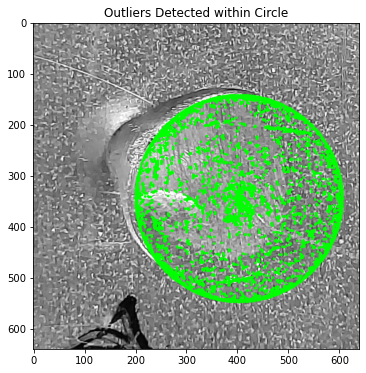

In [13]:
output_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
all_outliers = np.vstack(all_outliers).astype(int)
margin = 1

for x, y, _ in all_outliers:
    x_min = max(0, x - margin)
    y_min = max(0, y - margin)
    x_max = min(gray.shape[1], x + margin)
    y_max = min(gray.shape[0], y + margin)

    # Check if inside the circle center
    if (x - cx_resized)**2 + (y - cy_resized)**2 <= r_resized**2:
        cv2.rectangle(output_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Final display
plt.figure(figsize=(6, 6))
plt.imshow(output_img)
plt.title("Outliers Detected within Circle")
# plt.axis('off')
plt.show()

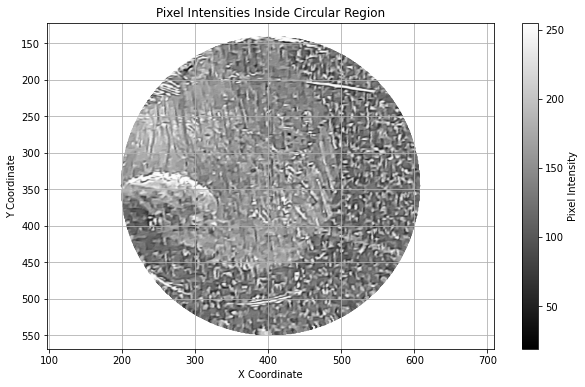

In [14]:
import numpy as np
import matplotlib.pyplot as plt

gray=cv2.cvtColor(cropped_img,cv2.COLOR_RGB2GRAY)
# Assume `gray` is a grayscale version of a resized 640x640 image
gray = cv2.resize(gray, (640, 640))  # just to be sure

H, W = gray.shape

# Step 1: Generate all coordinates
yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

# Step 2: Create circular mask
mask = (xx - cx_resized)**2 + (yy - cy_resized)**2 <= r_resized**2

# Step 3: Extract coordinates and intensities
x_vals = xx[mask].flatten()
y_vals = yy[mask].flatten()
intensities = gray[mask].flatten()

# Scatter plot: intensity vs coordinates (pure numerical)
plt.figure(figsize=(10, 6))
sc = plt.scatter(x_vals, y_vals, c=intensities, cmap='gray', s=5)
plt.colorbar(sc, label='Pixel Intensity')
plt.title('Pixel Intensities Inside Circular Region')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True)
plt.show()

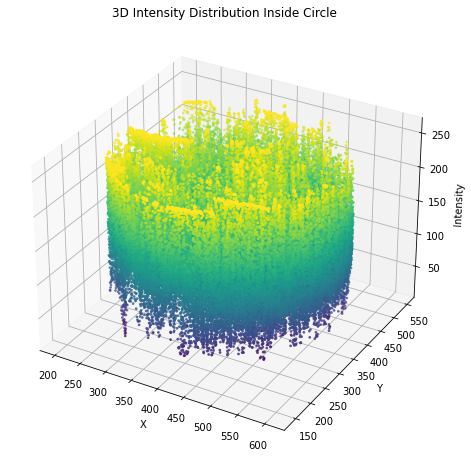

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, intensities, c=intensities, cmap='viridis', s=3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')
ax.set_title('3D Intensity Distribution Inside Circle')
plt.show()

In [16]:
from sklearn.ensemble import IsolationForest
X = np.column_stack((x_vals, y_vals, intensities))
clf = IsolationForest(contamination=0.2, random_state=42,n_estimators=200,bootstrap=True)
preds = clf.fit_predict(X)
outliers = X[preds == -1]

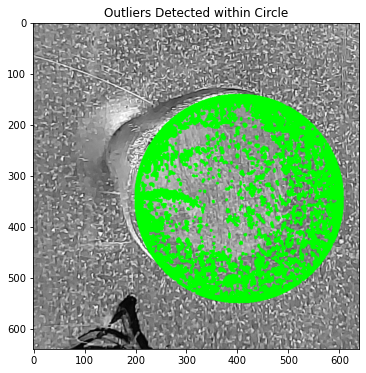

In [17]:
output_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
all_outliers = np.vstack(outliers).astype(int)
margin = 1

for x, y, _ in all_outliers:
    x_min = max(0, x - margin)
    y_min = max(0, y - margin)
    x_max = min(gray.shape[1], x + margin)
    y_max = min(gray.shape[0], y + margin)

    # Check if inside the circle center
    if (x - cx_resized)**2 + (y - cy_resized)**2 <= r_resized**2:
        cv2.rectangle(output_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Final display
plt.figure(figsize=(6, 6))
plt.imshow(output_img)
plt.title("Outliers Detected within Circle")
# plt.axis('off')
plt.show()

In [4]:
def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)



In [5]:
def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr

(406, 406, 3)


C:\Users\pavan kumar\AppData\Local\Temp\ipykernel_28744\2140991627.py:26: RuntimeWarning: divide by zero encountered in log10
  return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


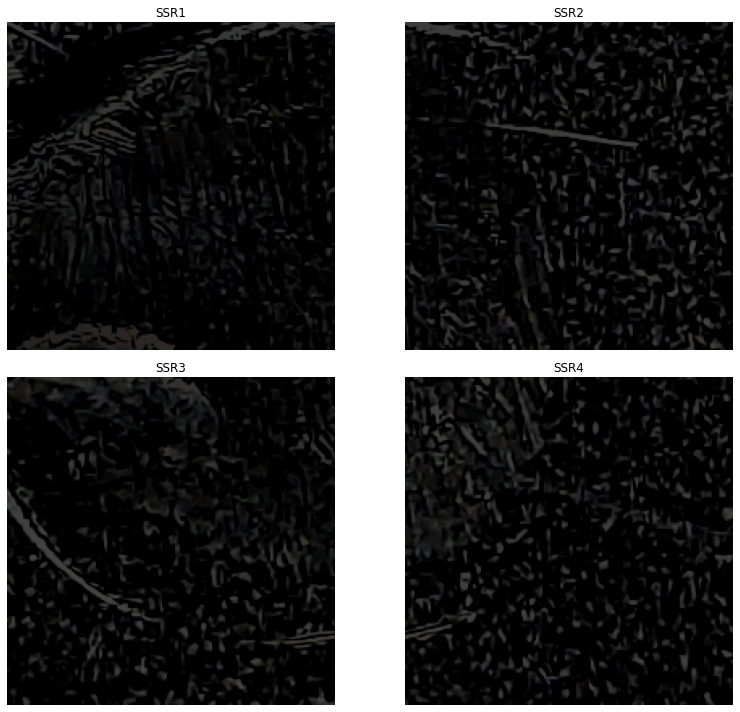

In [20]:
copy=cv2.resize(cropped_img,(640,640))
copy=copy[cy_resized-r_resized:cy_resized+r_resized,cx_resized-r_resized:cx_resized+r_resized]
print(copy.shape)
cy=copy.shape[0]//2
cx=copy.shape[1]//2
Q1=copy[0:cy,0:cx,]
Q2=copy[0:cy,cx:,]
Q3=copy[cy:,0:cx,]
Q4=copy[cy:,cx:,]
ssr1=ssr(Q1,50)
ssr2=ssr(Q2,50)
ssr3=ssr(Q3,50)
ssr4=ssr(Q4,250)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(ssr1, cmap='gray')
plt.title('SSR1')
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(ssr2, cmap='gray')
plt.title('SSR2')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(ssr3, cmap='gray')
plt.title('SSR3')
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(ssr4, cmap='gray')
plt.title('SSR4')
plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
# loop for saving ssr/hed for all spots




# for i in range(3,25):
#     img_no=i
#     img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#     #results = model(img_path)

#     results = model(img_path,
#                     conf=0.1,
#                     iou=0.4,
#                     agnostic_nms=True,
#                     max_det=1)

#     mask = 1- results[0].masks.data[0].detach().numpy()

#     box = results[0].boxes.xyxy[0].detach().numpy()
#     x1, y1, x2, y2 = map(int, box)

#     sample=img[y1:y2,x1:x2]

#     x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
#     cropped_img = img[y1_p:y2_p, x1_p:x2_p]

#     mask=cv2.resize(mask,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_NEAREST)
#     mask=mask[y1_p:y2_p,x1_p:x2_p]
#     mask=cv2.resize(mask,(640,640))

#     gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)

#     # Apply Gaussian Blur to reduce noise (important for HoughCircles)
#     blurred = cv2.GaussianBlur(gray, (9, 9), 2)

#     # Detect circles using HoughCircles
#     circles = cv2.HoughCircles(
#         blurred,
#         cv2.HOUGH_GRADIENT,
#         dp=1.2,
#         minDist=100,
#         param1=50,   # Higher threshold for internal Canny (not related to Canny usage outside Hough)
#         param2=40,   # Circle detection threshold (reduce if nothing found)
#         minRadius=350,
#         maxRadius=450
#     )

#     output = cropped_img.copy()
#     # Draw the largest detected circle
#     if circles is not None:
#         # Round and take only the first circle
#         x, y, r = np.round(circles[0][0]).astype("int")


#     H_orig, W_orig = output.shape[:2]

#     # Resize target
#     H_new, W_new = 640, 640

#     # Scaling factors
#     scale_x = W_new / W_orig
#     scale_y = H_new / H_orig

#     # Rescaled circle center and radius
#     cx_resized = int(x * scale_x)
#     cy_resized = int(y * scale_y)
#     r_resized  = int(r * (scale_x + scale_y) / 2)

#     copy=cv2.resize(cropped_img,(640,640))
#     copy=copy[cy_resized-r_resized:cy_resized+r_resized,cx_resized-r_resized:cx_resized+r_resized]

#     cy=copy.shape[0]//2
#     cx=copy.shape[1]//2
#     Q1=copy[0:cy,0:cx,]
#     Q2=copy[0:cy,cx:,]
#     Q3=copy[cy:,0:cx,]
#     Q4=copy[cy:,cx:,]

#     # ssr1=ssr(Q1,50)
#     # ssr2=ssr(Q2,50)
#     # ssr3=ssr(Q3,50)
#     # ssr4=ssr(Q4,250)

#     net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "hed_pretrained_bsds.caffemodel")

#     images = [Q1, Q2, Q3, Q4]
#     hed_outputs = []

#     for image in images:
#         (H,W)=image.shape[:2]
#         blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H), swapRB=False, crop=False)
#         net.setInput(blob)
#         hed = net.forward()
#         hed = cv2.resize(hed[0, 0], (W, H))
#         hed = (255 * hed).astype("uint8")
#         hed_outputs.append(hed)

# # Unpack results if needed
#     hed1, hed2, hed3, hed4 = hed_outputs

#     plt.figure(figsize=(12, 10))

#     plt.subplot(2, 2, 1)
#     plt.imshow(hed1, cmap='gray')
#     plt.title('HED1')
#     plt.axis("off")

#     plt.subplot(2, 2, 2)
#     plt.imshow(hed2, cmap='gray')
#     plt.title('HED2')
#     plt.axis("off")

#     plt.subplot(2, 2, 3)
#     plt.imshow(hed3, cmap='gray')
#     plt.title('HED3')
#     plt.axis("off")

#     plt.subplot(2, 2, 4)
#     plt.imshow(hed4, cmap='gray')
#     plt.title('HED4')
#     plt.axis("off")

#     plt.tight_layout()
#     plt.savefig(rf"HED Results\{i}.jpg",format='jpg',dpi=300)




In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
from Rbeast import beast



def extract_radial_profiles(image, cx, cy, radius, angle_step=15):
    profiles = []
    angles = np.deg2rad(np.arange(0, 360, angle_step))

    for theta in angles:
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        valid_intensities = []
        valid_distances = []

        for r, c in zip(rr, cc):
            if 0 <= r < image.shape[0] and 0 <= c < image.shape[1]:
                intensity = image[r, c]
                distance = np.sqrt((c - cx)**2 + (r - cy)**2)

                valid_intensities.append(intensity)
                valid_distances.append(distance)

        profiles.append((np.array(valid_intensities, dtype=np.float32),
                         np.array(valid_distances, dtype=np.float32)))

    return profiles, angles

# def run_beast_with_trend(profiles, angles,cx,cy,radius):
#     change_points_x=[]
#     change_points_y=[]
#     x_min_int,y_min_int=[],[]

#     for idx, (intensities, distances) in enumerate(profiles):
#         if len(intensities) < 10:
#             continue
        
#         y = np.asarray(intensities, dtype=np.float32)
#         t = np.asarray(distances, dtype=np.float32)

#         # Sort by distance (just in case)
#         sort_idx = np.argsort(t)
#         t = t[sort_idx]
#         y = y[sort_idx]

#         # Ensure correct shape: (N,) not (N,1)
#         y = y.flatten()
#         t = t.flatten()
#         options = {
#         "trend": {"prior": {"cpMinSep": 1, "cpPr": 0.01}}
#         }

#         metadata_dict={
#             "season": "none",   # explicitly disabling seasonal detection
#             "period": 0,        # no periodicity
#             "trend": {
#             "order": 1,     # smoother trend
#             "prior": {
#                 "cpMinSep": 2,
#                 "cpPr": 0.01,
#                 "maxCP": 1,
#                 "ncpPrior": {"mean": 0, "sd": 1}
#                 }
#                 }
#                 }
        

#         # Run BEAST with time argument explicitly passed
#         try:
#             result = beast(y, time=t, metadata=metadata_dict)
#         except Exception as e:
#             print(f"BEAST failed at angle {np.rad2deg(angles[idx]):.0f}°: {e}")
#             continue





#         # plt.figure(figsize=(8,4))
#         # plt.title(f"Radial profile at {np.rad2deg(angles[idx]):.0f}° with BEAST Change Points")
#         # plt.plot(t, y, label='Intensity')


        
#         # if hasattr(result, 'season') and result.season.cp  is not None:
#         #     added_label = False
#         #     for cp in result.season.cp :
#         #         if not added_label:
#         #             plt.axvline(x=cp, color='r', linestyle='--', label='Trend Change Point')
#         #             added_label = True
#         #         else:
#         #             plt.axvline(x=cp, color='r', linestyle='--')

#         # plt.xlabel('Distance from center (pixels)')
#         # plt.ylabel('Intensity')
#         # plt.legend()
#         # plt.tight_layout()
#         # plt.show()

#         last_cp=result.trend.cp[-1]
#         if(last_cp !=np.nan):
#             angle_rad = angles[idx]
#             x_last=cx+ last_cp*np.cos(angle_rad)
#             y_last=cy+last_cp*np.sin(angle_rad)
#             change_points_x.append(x_last)
#             change_points_y.append(y_last)

#         min_int=np.argmin(y)
#         x_min=cx+t[min_int]*np.cos(angle_rad)
#         y_min=cy+t[min_int]*np.sin(angle_rad)
        
#         x_min_int.append(x_min)
#         y_min_int.append(y_min)
        
#         # plt.figure(figsize=(6, 6))
#         # plt.imshow(copy, cmap='gray')  # Not transposed; (row, col) = (y, x)
#         # plt.title(f"BEAST Change Points at {np.rad2deg(angle_rad):.0f}°")
#         # plt.axis('off')

#         # # Plot center
#         # plt.plot(cx, cy, 'go', markersize=5, label='Center')

#         # # Plot change points along the angle
#         # for i, cp in enumerate(result.trend.cp):
#         #     x = cx + cp * np.cos(angle_rad)
#         #     y = cy + cp * np.sin(angle_rad)
#         #     plt.plot([cx, x], [cy, y], linestyle='--', color='red', alpha=0.7)
#         #     if i == 0:
#         #         plt.plot([], [], 'r--', label='Change Point')

#         # plt.legend()
#         # plt.tight_layout()
#         # plt.savefig(rf"Comparison 2\{np.rad2deg(angle_rad):.0f}_processed.jpg",format='jpg',dpi=300)
#         # plt.show()

#     print(f"minimum intensity X:{x_min_int}")
#     print(f"minimum intensity X:{y_min_int}")
#     plt.figure(figsize=(6,6))
#     plt.imshow(copy,cmap='gray')
#     plt.title("Last Beast")
#     plt.axis('off')

#     plt.scatter(x_min_int,y_min_int,color='red',s=15)
#     plt.tight_layout()
#     plt.show()

In [5]:


model = YOLO('best.pt')

#for i in range(3,25):
img_no=11

img_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\{img_no}.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#results = model(img_path)

results = model(img_path,
                conf=0.1,
                iou=0.4,
                agnostic_nms=True,
                max_det=1)

mask = 1- results[0].masks.data[0].detach().numpy()

box = results[0].boxes.xyxy[0].detach().numpy()
x1, y1, x2, y2 = map(int, box)

sample=img[y1:y2,x1:x2]

x1_p, y1_p, x2_p, y2_p = expand_crop(x1, y1, x2, y2, 300, img.shape)
cropped_img = img[y1_p:y2_p, x1_p:x2_p]

mask=cv2.resize(mask,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_NEAREST)
mask=mask[y1_p:y2_p,x1_p:x2_p]
mask=cv2.resize(mask,(640,640))

gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise (important for HoughCircles)
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=50,   # Higher threshold for internal Canny (not related to Canny usage outside Hough)
    param2=40,   # Circle detection threshold (reduce if nothing found)
    minRadius=350,
    maxRadius=450
)

output = cropped_img.copy()
# Draw the largest detected circle
if circles is not None:
    # Round and take only the first circle
    x, y, r = np.round(circles[0][0]).astype("int")


H_orig, W_orig = output.shape[:2]

# Resize target
H_new, W_new = 640, 640

# Scaling factors
scale_x = W_new / W_orig
scale_y = H_new / H_orig

# Rescaled circle center and radius
cx_resized = int(x * scale_x)
cy_resized = int(y * scale_y)
r_resized  = int(r * (scale_x + scale_y) / 2)



image 1/1 C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot_Test\Spot Macro\11.jpg: 640x640 1 spot, 1128.3ms
Speed: 18.9ms preprocess, 1128.3ms inference, 41.8ms postprocess per image at shape (1, 3, 640, 640)


In [169]:
# # NORMAL MINIMUM INTENSITIES
# copy=cv2.resize(cropped_img,(640,640))
# copy=cv2.cvtColor(copy,cv2.COLOR_RGB2GRAY)
# # copy = cv2.equalizeHist(copy)
# # # Sobel operator
# # sobel_x = cv2.Sobel(copy, cv2.CV_64F, 1, 0, ksize=3)
# # sobel_y = cv2.Sobel(copy, cv2.CV_64F, 0, 1, ksize=3)
# # sobel = cv2.magnitude(sobel_x, sobel_y)

# # # # Normalize to 0-255
# # sobel= cv2.convertScaleAbs(sobel)
# # copy = cv2.GaussianBlur(sobel, (5, 5), 0)
# # copy=ssr(copy,10)
# profiles,angles= extract_radial_profiles(copy, cx_resized, cy_resized, r_resized,angle_step=1)
# #run_beast_with_trend(profiles,angles,cx_resized,cy_resized,r_resized)

# x_min_int_normal,y_min_int_normal=[],[]

# for idx, (intensities, distances) in enumerate(profiles):
#     if len(intensities) < 10:
#         continue
        
#     y = np.asarray(intensities, dtype=np.float32)   
#     t = np.asarray(distances, dtype=np.float32)

#         # Sort by distance (just in case)
#     sort_idx = np.argsort(t)
#     t = t[sort_idx]
#     y = y[sort_idx]

#         # Ensure correct shape: (N,) not (N,1)
#     y = y.flatten()
#     t = t.flatten()

#     angle_rad=angles[idx]

#     min_int=np.argmin(y)
#     x_min=cx_resized+t[min_int]*np.cos(angle_rad)
#     y_min=cy_resized+t[min_int]*np.sin(angle_rad)
        
#     x_min_int_normal.append(x_min)
#     y_min_int_normal.append(y_min)


# points_normal=np.column_stack((x_min_int_normal,y_min_int_normal))

# crop_again=cv2.resize(cropped_img,(640,640))
# crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)
# plt.figure(figsize=(6,6))
# plt.imshow(crop_again,cmap='gray')
# plt.axis('off')
# plt.title(f"Min Intensitiy of {img_no} spot")
# plt.scatter(points_normal[:,0],points_normal[:,1],color='red',s=10)

# detected_circlemask=np.ones_like(crop_again,dtype=np.uint8)
# cv2.circle(detected_circlemask,(int(cx_resized),int(cy_resized)),int(r_resized),0,thickness=-1)
# detected_circlemask=(detected_circlemask>0).astype(np.uint8)

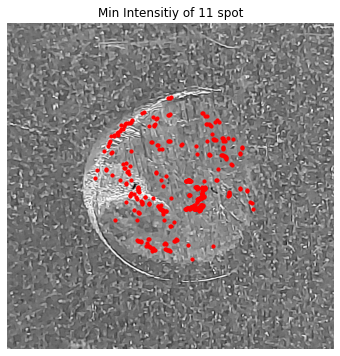

In [6]:
# PROCESSED MINIMUM INTENSITIES
copy=cv2.resize(cropped_img,(640,640))
copy=cv2.cvtColor(copy,cv2.COLOR_RGB2GRAY)
copy = cv2.equalizeHist(copy)
# Sobel operator
sobel_x = cv2.Sobel(copy, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(copy, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

# # Normalize to 0-255
sobel= cv2.convertScaleAbs(sobel)
copy = cv2.GaussianBlur(sobel, (5, 5), 0)
# copy=ssr(copy,10)
profiles,angles= extract_radial_profiles(copy, cx_resized, cy_resized, r_resized,angle_step=1)
#run_beast_with_trend(profiles,angles,cx_resized,cy_resized,r_resized)

x_min_int_processed,y_min_int_processed=[],[]

for idx, (intensities, distances) in enumerate(profiles):
    if len(intensities) < 10:
        continue
        
    y = np.asarray(intensities, dtype=np.float32)   
    t = np.asarray(distances, dtype=np.float32)

        # Sort by distance (just in case)
    sort_idx = np.argsort(t)
    t = t[sort_idx]
    y = y[sort_idx]

        # Ensure correct shape: (N,) not (N,1)
    y = y.flatten()
    t = t.flatten()

    angle_rad=angles[idx]

    min_int=np.argmin(y)
    x_min=cx_resized+t[min_int]*np.cos(angle_rad)
    y_min=cy_resized+t[min_int]*np.sin(angle_rad)
        
    x_min_int_processed.append(x_min)
    y_min_int_processed.append(y_min)


points_processed=np.column_stack((x_min_int_processed,y_min_int_processed))

crop_again=cv2.resize(cropped_img,(640,640))
crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.axis('off')
plt.title(f"Min Intensitiy of {img_no} spot")
plt.scatter(points_processed[:,0],points_processed[:,1],color='red',s=10)


In [135]:
# height, width = 640, 640
# blank_image = np.zeros((height, width), dtype=np.uint8)

# # Step 2: Plot points on the canvas
# for x, y in zip(x_min_int_normal, y_min_int_normal):
#     cv2.circle(blank_image, (int(x), int(y)), radius=1, color=255, thickness=-1)

# # Optional: Save or visualize
# # plt.figure(figsize=(6, 6))
# # plt.imshow(blank_image, cmap='gray')
# # plt.title("Points to Image")
# # plt.axis('off')
# # plt.tight_layout()
# # plt.show()

In [136]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume 'blank_image' is already created from previous steps
# # Apply Gaussian Blur to smooth edges
# blurred = cv2.GaussianBlur(blank_image, (9, 9), 2)

# # Apply Hough Circle Transform
# circles = cv2.HoughCircles(
#     blurred,                     # Input image
#     cv2.HOUGH_GRADIENT,          # Detection method
#     dp=1,                        # Inverse ratio of accumulator resolution
#     minDist=20,                  # Minimum distance between detected centers
#     param1=100,                  # Higher threshold for Canny edge detection
#     param2=15,                   # Accumulator threshold (smaller = more sensitive)
#     minRadius=0,                 # Minimum circle radius
#     maxRadius=r_resized                  # Maximum circle radius (0 = no max)
# )

# # Convert original to color to overlay circles
# circle_img = cv2.cvtColor(blank_image, cv2.COLOR_GRAY2BGR)

# # Draw detected circles
# if circles is not None:
#     # Round and take only the first circle
#     cx_new, cy_new, r_new = np.round(circles[0][0]).astype("int")
    
#     # Draw the circle and its center
#     cv2.circle(circle_img, (cx_new, cy_new), r_new, (0, 255, 0), 2)   # Circle outline
#     cv2.circle(circle_img, (cx_new, cy_new), 2, (0, 0, 255), 3)   # Circle center

# # Show the result
# plt.figure(figsize=(6, 6))
# plt.imshow(cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB))
# plt.title("Hough Circle Detection")
# plt.axis('off')
# plt.tight_layout()
# plt.show()

# circlemask_normal=np.ones_like(crop_again,dtype=np.uint8)
# cv2.circle(circlemask_normal,(int(cx_new),int(cy_new)),int(r_new),0,thickness=-1)
# circlemask_normal=(circlemask_normal>0).astype(np.uint8)






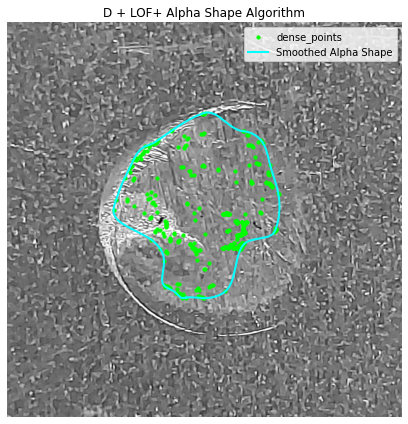

51936.94681833975


In [22]:
# New workflow: Density + LOF + Alpha Shape

# For Acquiring Processed Alpha Mask
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import alphashape
from scipy.interpolate import splprep, splev
from shapely.geometry import Point


crop_again=cv2.resize(cropped_img,(640,640))
crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)


# DBSCAN to detect dense core
db = DBSCAN(eps=30, min_samples=3).fit(points_processed)
labels = db.labels_

# Keep only dense points (label != -1)
dense_points = points_processed[labels != -1]


# Step 2: Apply LOF for outlier detection
lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
labels_lof = lof.fit_predict(dense_points)  # 1 = inlier, -1 = outlier

# Step 3: Separate inliers and outliers
inliers = dense_points[labels_lof == 1]
outliers = dense_points[labels_lof == -1]

alpha = 0.02 # Adjust as needed (lower = tighter boundary)

shape = alphashape.alphashape(inliers, alpha)

# Step 2: Plotting
plt.figure(figsize=(6,6))
plt.imshow(crop_again, cmap='gray')
plt.axis('off')
plt.title("D + LOF+ Alpha Shape Algorithm")

# Scatter inlier points
plt.scatter(inliers[:, 0], inliers[:, 1], s=10, color='lime', label='dense_points')

# Plot alpha shape boundary
if shape.geom_type == 'Polygon':
    x, y = shape.exterior.xy
elif shape.geom_type == 'MultiPolygon':
    for polygon in shape.geoms:
        x, y = polygon.exterior.xy

alphamask_processed = np.ones_like(crop_again, dtype=np.uint8)


x, y = shape.exterior.xy
shape_points = np.array([x, y])
tck, u = splprep(shape_points, s=2.0, per=True)
x_smooth, y_smooth = splev(np.linspace(0, 1, 400), tck)

contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
cv2.fillPoly(alphamask_processed, [contour], 0)


plt.plot(x_smooth, y_smooth, color='cyan', linewidth=2, label='Smoothed Alpha Shape')
# plt.imshow(alphamask_processed,cmap='gray')
plt.legend()
plt.tight_layout()
# plt.savefig(rf"Detection_Trials\{img_no}_Density+LOF+Alpha.jpg",format="jpg",dpi=300)
plt.show()
print(shape.area)


In [164]:
# # New workflow: Density + LOF + Alpha Shape

# # For Acquiring Normal Alpha Mask
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import LocalOutlierFactor
# import alphashape
# from scipy.interpolate import splprep, splev
# from shapely.geometry import Point


# crop_again=cv2.resize(cropped_img,(640,640))
# crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)


# # DBSCAN to detect dense core
# db = DBSCAN(eps=30, min_samples=3).fit(points_normal)
# labels = db.labels_

# # Keep only dense points (label != -1)
# dense_points = points_normal[labels != -1]


# # Step 2: Apply LOF for outlier detection
# lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
# labels_lof = lof.fit_predict(dense_points)  # 1 = inlier, -1 = outlier

# # Step 3: Separate inliers and outliers
# inliers = dense_points[labels_lof == 1]
# outliers = dense_points[labels_lof == -1]

# alpha = 0.02 # Adjust as needed (lower = tighter boundary)

# shape = alphashape.alphashape(inliers, alpha)

# # Step 2: Plotting
# plt.figure(figsize=(6,6))
# plt.imshow(crop_again, cmap='gray')
# plt.axis('off')
# plt.title("D + LOF+ Alpha Shape Algorithm")

# # Scatter inlier points
# plt.scatter(inliers[:, 0], inliers[:, 1], s=10, color='lime', label='dense_points')

# # Plot alpha shape boundary
# if shape.geom_type == 'Polygon':
#     x, y = shape.exterior.xy
# elif shape.geom_type == 'MultiPolygon':
#     for polygon in shape.geoms:
#         x, y = polygon.exterior.xy

# alphamask_normal = np.ones_like(crop_again, dtype=np.uint8)


# x, y = shape.exterior.xy
# shape_points = np.array([x, y])
# tck, u = splprep(shape_points, s=2.0, per=True)
# x_smooth, y_smooth = splev(np.linspace(0, 1, 400), tck)

# contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
# cv2.fillPoly(alphamask_normal, [contour], 0)


# plt.plot(x_smooth, y_smooth, color='cyan', linewidth=2, label='Smoothed Alpha Shape')
# # plt.imshow(alphamask_normal,cmap='gray')
# plt.legend()
# plt.tight_layout()
# # plt.savefig(rf"Detection_Trials\{img_no}_Density+LOF+Alpha.jpg",format="jpg",dpi=300)
# # plt.show()
# print(shape.area)


In [165]:
# plt.figure(figsize=(12,12))
# plt.subplot(2,2,1)
# plt.imshow(crop_again*detected_circlemask,cmap='gray')
# plt.axis('off')
# plt.subplot(2,2,2)
# plt.imshow(crop_again*circlemask_normal,cmap='gray')
# plt.axis('off') 
# plt.subplot(2,2,3)
# plt.imshow(crop_again*alphamask_normal,cmap='gray')
# plt.axis('off')
# plt.subplot(2,2,4)
# plt.imshow(crop_again*alphamask_processed,cmap='gray')
# plt.axis('off')


(-0.5, 639.5, 639.5, -0.5)

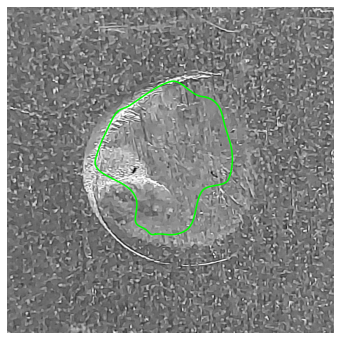

In [24]:
trial=np.column_stack((x_smooth,y_smooth))
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.plot(trial[:,0],trial[:,1],color='lime')
plt.axis('off')

In [10]:
import numpy as np

def scale_polygon_points(points, scale=1.1):
    # Step 1: Compute centroid
    centroid = np.mean(points, axis=0)

    # Step 2: Shift points to origin, scale, shift back
    scaled_points = (points - centroid) * scale + centroid
    return scaled_points


In [23]:
 # Example alpha shape
scaled_trial_2 = scale_polygon_points(trial, scale=1.25) 
scaled_trial_1 = scale_polygon_points(trial, scale=0.85)   # 10% outward


(-0.5, 639.5, 639.5, -0.5)

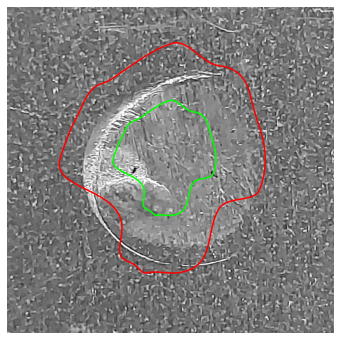

In [13]:

plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.plot(scaled_trial_2[:,0],scaled_trial_2[:,1],color='red')
plt.plot(scaled_trial_1[:,0],scaled_trial_1[:,1],color='lime')
plt.axis('off')

In [14]:
region= np.vstack((scaled_trial_1, scaled_trial_2[::-1]))
# region = np.vstack((scaled_trial, trial[::-1], [scaled_trial[0]]))


In [15]:
from skimage.draw import line
from shapely.geometry import Point, Polygon
import numpy as np

def extract_radial_profiles_in_region(image, cx, cy, radius, region, angle_step=15):
    """
    Extract radial profiles only for pixels inside a polygonal region.
    
    Parameters:
    - image: 2D grayscale image
    - cx, cy: center point
    - radius: max radius of sampling
    - region: list or array of (x, y) points defining the polygon
    - angle_step: angle step in degrees
    
    Returns:
    - profiles: list of (intensities, distances) for each angle
    - angles: list of angles (in radians)
    """
    polygon = Polygon(region)  # Create region polygon
    profiles = []
    angles = np.deg2rad(np.arange(0, 360, angle_step))

    for theta in angles:
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        valid_intensities = []
        valid_distances = []

        for r, c in zip(rr, cc):
            if 0 <= r < image.shape[0] and 0 <= c < image.shape[1]:
                # Only include if point is inside the region
                if polygon.contains(Point(c, r)):
                    intensity = image[r, c]
                    distance = np.sqrt((c - cx)**2 + (r - cy)**2)

                    valid_intensities.append(intensity)
                    valid_distances.append(distance)

        profiles.append((np.array(valid_intensities, dtype=np.float32),
                         np.array(valid_distances, dtype=np.float32)))

    return profiles, angles


In [16]:
prof,ang=extract_radial_profiles_in_region(crop_again,cx_resized,cy_resized,r_resized,region,angle_step=1)


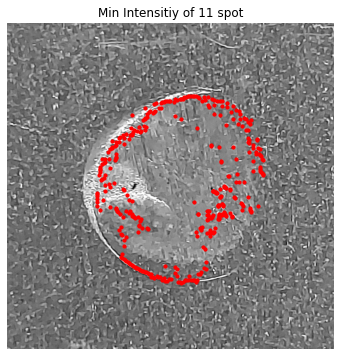

In [17]:
def get_points_region(prof,ang):
    x_min_int_region,y_min_int_region=[],[]


    for idx, (intensities, distances) in enumerate(prof):
        if len(intensities) < 10:
            continue
            
        y = np.asarray(intensities, dtype=np.float32)   
        t = np.asarray(distances, dtype=np.float32)

            # Sort by distance (just in case)
        sort_idx = np.argsort(t)
        t = t[sort_idx]
        y = y[sort_idx]

            # Ensure correct shape: (N,) not (N,1)
        y = y.flatten()
        t = t.flatten()

        angle_rad=angles[idx]

        min_int=np.argmin(y)
        x_min=cx_resized+t[min_int]*np.cos(angle_rad)
        y_min=cy_resized+t[min_int]*np.sin(angle_rad)
            
        x_min_int_region.append(x_min)
        y_min_int_region.append(y_min)


    points_region=np.column_stack((x_min_int_region,y_min_int_region))
    
    return points_region

points_region=get_points_region(prof,ang)

crop_again=cv2.resize(cropped_img,(640,640))
crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.axis('off')
plt.title(f"Min Intensitiy of {img_no} spot")
plt.scatter(points_region[:,0],points_region[:,1],color='red',s=10)





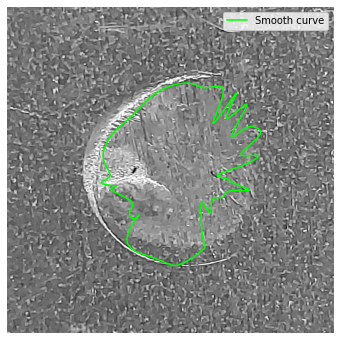

In [18]:
from scipy.interpolate import splprep, splev
import numpy as np
import matplotlib.pyplot as plt

def smooth_closed_curve(points, smoothness=0):
    points = np.array(points)
    # Ensure closed by repeating the first point at the end if needed
    if not np.allclose(points[0], points[-1]):
        points = np.vstack([points, points[0]])

    # Fit a periodic spline (closed curve)
    tck, u = splprep([points[:,0], points[:,1]], s=smoothness, per=True)

    # Evaluate spline at many points for smoothness
    u_fine = np.linspace(0, 1, 500)
    x_smooth, y_smooth = splev(u_fine, tck)
    return np.column_stack([x_smooth, y_smooth])

# Example usage:
smoothed_boundary = smooth_closed_curve(points_region, smoothness=80000)

# Optional: visualize
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
# plt.plot(points_region[:,0], points_region[:,1], 'o', label='Original points')
plt.plot(smoothed_boundary[:,0], smoothed_boundary[:,1], '-', label='Smooth curve',color='lime')
plt.legend()
plt.axis('off')
plt.savefig(rf'Detection_Trials\ {img_no} more fit.jpg',format='jpg',dpi=300)
plt.show()


Iteration No: 1


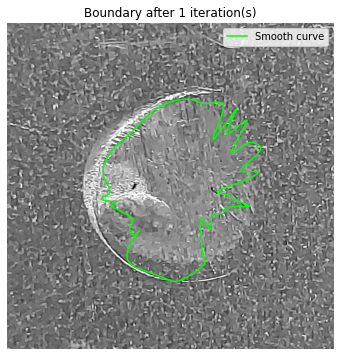

Iteration No: 2


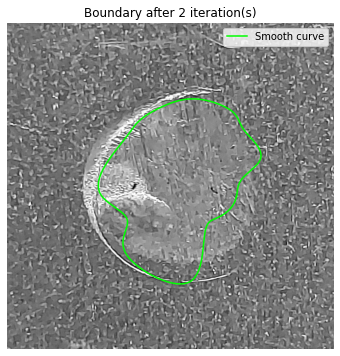

Iteration No: 3


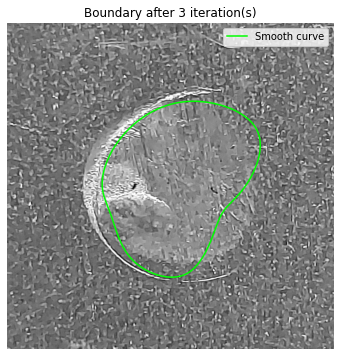

Iteration No: 4


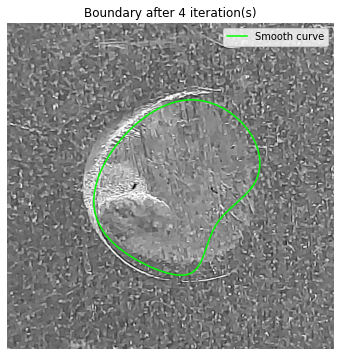

Iteration No: 5


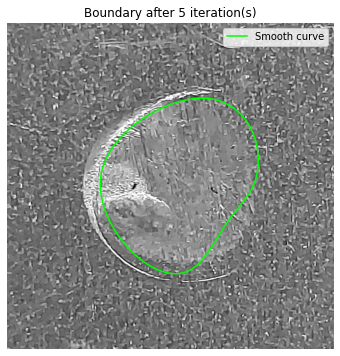

Iteration No: 6


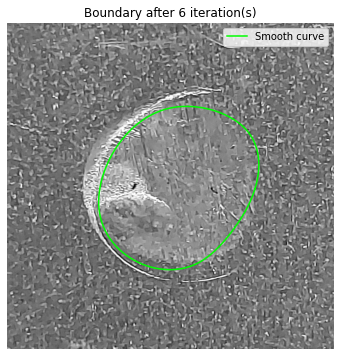

Iteration No: 7


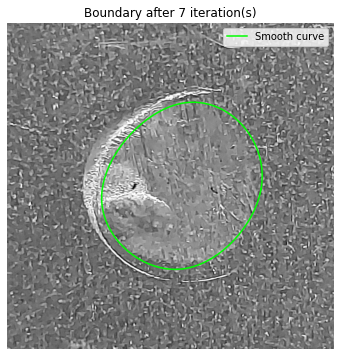

Iteration No: 8


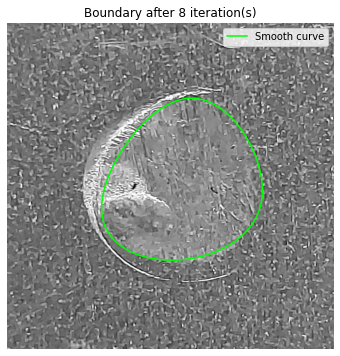

Iteration No: 9


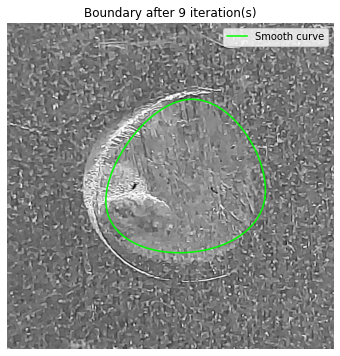

Iteration No: 10


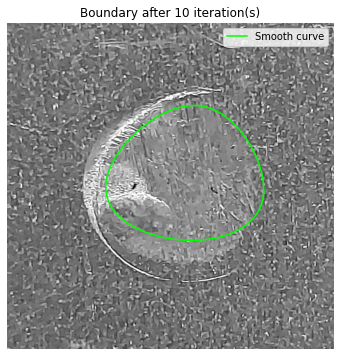

In [21]:
# Trying for an iterative implemtation
iter=10
trial_iter=trial

for i in range(iter):
    print(f"Iteration No: {i+1}")
    trial_iter=np.column_stack((x_smooth,y_smooth))
    scaled_trial_2 = scale_polygon_points(trial_iter, scale=1+(0.5/(i+1))) 
    scaled_trial_1 = scale_polygon_points(trial_iter, scale=1-(0.25/(i+1)))
    region= np.vstack((scaled_trial_1, scaled_trial_2[::-1]))   
    prof,ang=extract_radial_profiles_in_region(crop_again,cx_resized,cy_resized,r_resized,region,angle_step=1)
    points_region=get_points_region(prof,ang)
    smoothed_boundary = smooth_closed_curve(points_region, smoothness=80000 + 10*i)
    plt.figure(figsize=(6,6))
    plt.imshow(crop_again,cmap='gray')
    # plt.plot(points_region[:,0], points_region[:,1], 'o', label='Original points')
    plt.title(f"Boundary after {i+1} iteration(s)")
    plt.plot(smoothed_boundary[:,0], smoothed_boundary[:,1], '-', label='Smooth curve',color='lime')
    plt.legend()
    plt.axis('off')
    # plt.savefig(rf'Detection_Trials\ {img_no} more fit.jpg',format='jpg',dpi=300)
    plt.show()
    x_smooth, y_smooth=smoothed_boundary[:,0],smoothed_boundary[:,1]

    

In [95]:
from shapely.geometry import Point, Polygon
from skimage.draw import line
import numpy as np

def extract_first_points_in_region(cx, cy, radius, region, angle_step=1, image_shape=None):
    """
    Extract the first (closest to center) point inside the region for each radial angle.
    
    Parameters:
    - cx, cy: center point
    - radius: maximum search radius
    - region: (N, 2) array of polygon points defining region
    - angle_step: step in degrees
    - image_shape: (optional) to clip rays within image bounds
    
    Returns:
    - first_points: list of (x, y) points (one per angle)
    - angles: angles in radians
    """
    polygon = Polygon(region)
    angles = np.deg2rad(np.arange(0, 360, angle_step))
    first_points = []

    for theta in angles:
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        found = False
        for r, c in zip(rr, cc):
            if image_shape and (r < 0 or r >= image_shape[0] or c < 0 or c >= image_shape[1]):
                continue
            if polygon.contains(Point(c, r)):
                first_points.append((c, r))
                found = True
                break
        
        if not found:
            first_points.append((np.nan, np.nan))  # or you can skip or interpolate later

    return np.array(first_points), angles


In [101]:
first_points, angles = extract_first_points_in_region(
    cx_resized, cy_resized, r_resized,
    region=region,
    angle_step=1,
    image_shape=crop_again.shape
)



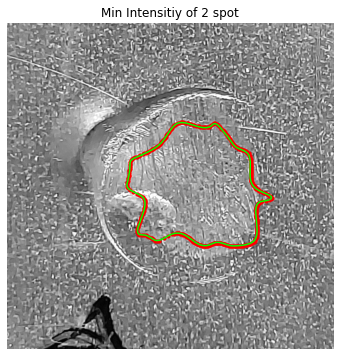

In [103]:
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.axis('off')
plt.title(f"Min Intensitiy of {img_no} spot")
plt.scatter(first_points[:,0],first_points[:,1],color='red',s=10)
plt.plot(scaled_trial_1[:,0],scaled_trial_1[:,1],color='lime')


In [107]:
from shapely.geometry import Point, Polygon
from skimage.draw import line
import numpy as np

def extract_min_point_per_ray(image, cx, cy, radius, region, angle_step=1):
    """
    Extract the (x, y) of the minimum intensity inside the polygon region
    along each radial ray (1 per angle).
    
    Returns exactly 360 points if angle_step=1.
    """
    polygon = Polygon(region)
    angles = np.deg2rad(np.arange(0, 360, angle_step))
    min_points = []

    for theta in angles:
        # Endpoint of the ray
        x_end = int(round(cx + radius * np.cos(theta)))
        y_end = int(round(cy + radius * np.sin(theta)))

        # Get line of pixels
        rr, cc = line(int(round(cy)), int(round(cx)), y_end, x_end)

        # Track minimum
        min_val = float('inf')
        min_coord = (np.nan, np.nan)

        for r, c in zip(rr, cc):
            if 0 <= r < image.shape[0] and 0 <= c < image.shape[1]:
                if polygon.contains(Point(c, r)):
                    val = image[r, c]
                    if val < min_val:
                        min_val = val
                        min_coord = (c, r)

        # Append exactly one (c, r) per angle
        min_points.append(min_coord)

    return np.array(min_points), angles


In [108]:
min_points, angles = extract_min_point_per_ray(
    crop_again, cx_resized, cy_resized, r_resized, region, angle_step=1
)


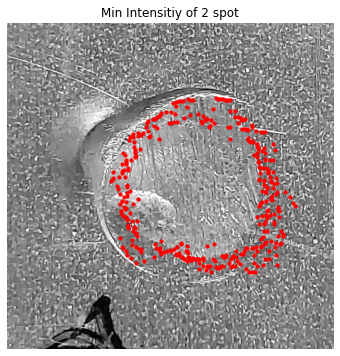

In [109]:
plt.figure(figsize=(6,6))
plt.imshow(crop_again,cmap='gray')
plt.axis('off')
plt.title(f"Min Intensitiy of {img_no} spot")
plt.scatter(min_points[:,0],min_points[:,1],color='red',s=10)


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def fit_polynomial_to_points(points_region, degree=3, flip_axes=True):
    """
    Fit a polynomial curve to a 2D point cloud. Supports fitting x = f(y) if flip_axes is True.
    
    Returns:
        x_curve: x-values of the fitted curve
        y_curve: y-values (used for plotting)
        model: Polynomial model
    """
    if flip_axes:
        # Fit x = f(y) instead of y = f(x)
        sorted_idx = np.argsort(points_region[:, 1])
        y = points_region[sorted_idx][:, 1]
        x = points_region[sorted_idx][:, 0]

        model = Polynomial.fit(y, x, deg=degree)
        y_curve = np.linspace(y.min(), y.max(), 300)
        x_curve = model(y_curve)
    else:
        sorted_idx = np.argsort(points_region[:, 0])
        x = points_region[sorted_idx][:, 0]
        y = points_region[sorted_idx][:, 1]

        model = Polynomial.fit(x, y, deg=degree)
        x_curve = np.linspace(x.min(), x.max(), 300)
        y_curve = model(x_curve)

    return x_curve, y_curve, model


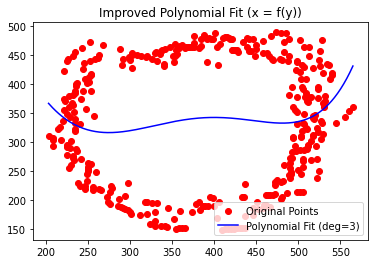

In [113]:
x_curve, y_curve, model = fit_polynomial_to_points(points_region, degree=5, flip_axes=False)


plt.scatter(points_region[:, 0], points_region[:, 1], color='red', label='Original Points')
plt.plot(x_curve, y_curve, color='blue', label='Polynomial Fit (deg=3)')
  # if image coordinates
plt.legend()
plt.title("Improved Polynomial Fit (x = f(y))")
plt.show()


In [434]:
# plt.figure(figsize=(6,6))
# plt.imshow(crop_again,cmap='gray')
# plt.axis('off')
# plt.title(f"Polynomial fit on alpha shape of {img_no} spot")

# plt.plot(x_curve_y, y_curve_y, color='blue', label='Polynomial Fit (deg=3)')
# plt.plot(x_curve_x, y_curve_x, color='blue', label='Polynomial Fit (deg=3)')
# plt.plot(t_y_1[:,0],t_y_1[:,1],color='lime')
# plt.plot(t_x_1[:,0],t_x_1[:,1],color='lime')

# plt.savefig(rf"Detection_Trials\fit_{img_no}.jpg",format='jpg',dpi=300)

In [435]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def merge_and_fit_polynomial(x1, y1, x2, y2, degree=3, mode='y_from_x', num_points=300):
    """
    Merge two curves and fit a single polynomial.

    mode = 'y_from_x' → fit y = f(x)
    mode = 'x_from_y' → fit x = f(y)
    """

    # Step 1: Stack both curves
    curve1 = np.column_stack((x1, y1))
    curve2 = np.column_stack((x2, y2))

    # Step 2: Reverse one if needed to ensure continuity
    if np.linalg.norm(curve1[-1] - curve2[0]) > np.linalg.norm(curve1[-1] - curve2[-1]):
        curve2 = curve2[::-1]

    # Step 3: Merge
    merged = np.vstack((curve1, curve2))

    if mode == 'y_from_x':
        merged = merged[np.argsort(merged[:, 0])]
        x = merged[:, 0]
        y = merged[:, 1]
        model = Polynomial.fit(x, y, deg=degree)
        x_fit = np.linspace(x.min(), x.max(), num_points)
        y_fit = model(x_fit)
        return x_fit, y_fit, model

    elif mode == 'x_from_y':
        merged = merged[np.argsort(merged[:, 1])]
        y = merged[:, 1]
        x = merged[:, 0]
        model = Polynomial.fit(y, x, deg=degree)
        y_fit = np.linspace(y.min(), y.max(), num_points)
        x_fit = model(y_fit)
        return x_fit, y_fit, model

    else:
        raise ValueError("mode must be 'y_from_x' or 'x_from_y'")


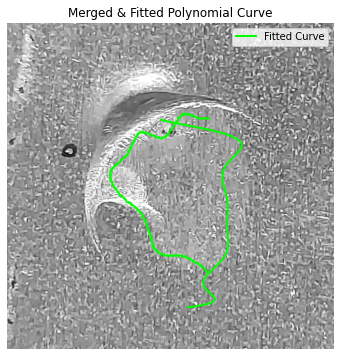

In [436]:
x_fit, y_fit, model = merge_and_fit_polynomial(x_curve_x, y_curve_x, x_curve_y, y_curve_y, mode='x_from_y',degree=10)
plt.figure(figsize=(6,6))
plt.imshow(crop_again, cmap='gray')
plt.plot(x_fit, y_fit, color='lime', linewidth=2, label='Fitted Curve')
plt.scatter(top_left[:,0],top_left[:,1],s=2,color='lime')
plt.scatter(bottom_left[:,0],bottom_left[:,1],s=2,color='lime')
plt.axis('off')
plt.legend()

plt.title("Merged & Fitted Polynomial Curve")
plt.savefig(rf"Detection_Trials/{img_no} more fit.jpg",format='jpg',dpi=300)
plt.show()


In [240]:
#import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Ensure both masks are binary (0 or 255) and same size

# # Convert original image to color if it's grayscale
# if len(crop_again.shape) == 2 or crop_again.shape[2] == 1:
#     image_color = cv2.cvtColor(crop_again, cv2.COLOR_GRAY2BGR)
# else:
#     image_color = crop_again.copy()

# # Create colored overlay for the mask (e.g., red overlay)
# overlay = np.zeros_like(image_color)
# overlay[final == 0] = [255, 0, 0]  # Red color for mask area

# # Blend the overlay on original image
# alpha = 0.8  # Transparency level
# overlayed_image = cv2.addWeighted(image_color, 1.0, overlay, alpha, 0)

# # Show result
# plt.figure(figsize=(6, 6))
# plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.title(f"Detected Spot {img_no}")
# plt.tight_layout()
# plt.savefig(rf"FinalSpotMask\{img_no}.jpg",format="jpg",dpi=300)
# plt.show()


In [ ]:
#Another workflow: LOF + Density + Alpha

# from sklearn.neighbors import LocalOutlierFactor
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
# from scipy.spatial import ConvexHull

# crop_again=cv2.resize(cropped_img,(640,640))
# crop_again=cv2.cvtColor(crop_again,cv2.COLOR_RGB2GRAY)

# # Step 1: Stack x_min_int and y_min_int into 2D points
# points = np.column_stack((x_min_int, y_min_int))

# # Step 2: Apply LOF for outlier detection
# lof = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
# labels_lof = lof.fit_predict(points)  # 1 = inlier, -1 = outlier

# # Step 3: Separate inliers and outliers
# inliers = points[labels_lof == 1]
# outliers = points[labels_lof == -1]




# # DBSCAN to detect dense core
# db = DBSCAN(eps=30, min_samples=10).fit(inliers)
# labels = db.labels_

# # Keep only dense points (label != -1)
# dense_points = inliers[labels != -1]

# # Plot image
# plt.figure(figsize=(6,6))
# plt.imshow(crop_again, cmap='gray')
# plt.axis('off')
# plt.title("Single Convex Hull on Dense Region")

# # Draw points
# plt.scatter(dense_points[:, 0], dense_points[:, 1], s=10, color='cyan', label='Dense Points')

# # Apply convex hull to all dense points together
# if len(dense_points) >= 3:
#     hull = ConvexHull(dense_points)
#     for simplex in hull.simplices:
#         plt.plot(dense_points[simplex, 0], dense_points[simplex, 1], 'r-', linewidth=2)

# plt.legend()
# plt.tight_layout()
# # plt.savefig(rf"Detection_Trials\{img_no}_density_based.jpg",format="jpg",dpi=300)
# plt.show()



# # Step 1: Compute alpha shape
# alpha = 0.02 # Adjust as needed (lower = tighter boundary)

# shape = alphashape.alphashape(dense_points, alpha)

# # Step 2: Plotting
# plt.figure(figsize=(6,6))
# plt.imshow(crop_again, cmap='gray')
# plt.axis('off')
# plt.title("LOF + D + Alpha Shape Algorithm")

# # Scatter inlier points
# plt.scatter(dense_points[:, 0], dense_points[:, 1], s=10, color='lime', label='dense_points')

# # Plot alpha shape boundary
# if shape.geom_type == 'Polygon':
#     x, y = shape.exterior.xy
#     plt.plot(x, y, color='cyan', linewidth=2, label='Alpha Shape')
# elif shape.geom_type == 'MultiPolygon':
#     for polygon in shape.geoms:
#         x, y = polygon.exterior.xy
#         plt.plot(x, y, color='cyan', linewidth=2)

# plt.legend()
# plt.tight_layout()
# plt.savefig(rf"Detection_Trials\{img_no}_alpha.jpg",format="jpg",dpi=300)
# plt.show()
